In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [3]:
# Save the input and target variables

#print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis =0))/targets.std()


In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets,test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_data.shape)
print(test_targets.shape)


(397, 10)
(45, 10)
(397, 10)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
         Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model
model = get_model()

Metal device set to: Apple M1


2022-05-25 20:02:05.220484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-25 20:02:05.221197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer="adam",loss="mse",metrics=["mae"])


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15,batch_size = 64,verbose= False
                   )


2022-05-25 20:02:05.406095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-25 20:02:05.820079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 20:02:06.301873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [10]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets,verbose= 2)


2/2 - 0s - loss: 0.9367 - mae: 0.7165 - 70ms/epoch - 35ms/step


[0.936745822429657, 0.7165200114250183]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

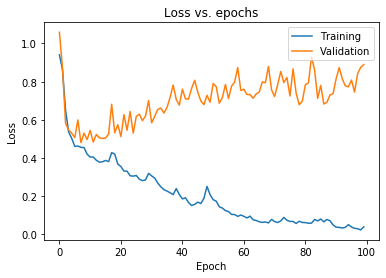

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dense(1)
    ])
    return model

In [41]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5,0.3)

In [16]:
# Compile the model
model.compile(optimizer="adam",loss="mse",metrics=["mae"])


In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split= 0.15,batch_size=64,verbose=False)


2022-05-25 20:02:13.828693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 20:02:14.368010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets, verbose=2)


2/2 - 0s - loss: 0.5863 - mae: 0.5836 - 59ms/epoch - 29ms/step


[0.5863398909568787, 0.5835506319999695]

#### Plot the learning curves

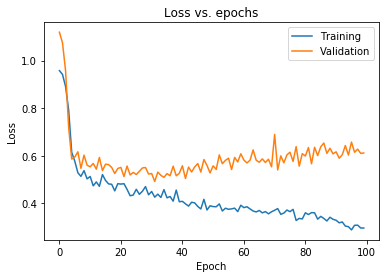

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training...")
        
    def on_epoch_begin(self,epoch, logs=None):
        print(f"Starting epoch (epoch)")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finnished batch {batch}")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finnished epoch {epoch}")
    
    def on_train_end(self, logs=None):
        print("Finished training!")
        
class TestCallback(Callback):
    def on_test_begin(self, logs=None):
        print("Starting testing...")
  
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finnished batch {batch}")
    
    def on_test_end(self, logs=None):
        print("Finished testing!")

class PredictionCallback(Callback):
    def on_predict_begin(self, logs=None):
        print("Starting prediction...")
  
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finnished batch {batch}")
    
    def on_predict_end(self, logs=None):
        print("Finished Prediction!")

In [21]:
# Re-build the model

model =get_regularised_model(1e-5,0.3)

In [22]:
# Compile the model

model.compile(optimizer="adam", loss="mse")

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets,epochs=3, batch_size=128,verbose=False,callbacks =[TrainingCallback()])

Starting training...
Starting epoch (epoch)
Training: Starting batch 0


2022-05-25 20:02:24.178972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Training: Finnished batch 0
Training: Starting batch 1
Training: Finnished batch 1
Training: Starting batch 2
Training: Finnished batch 2
Training: Starting batch 3
Training: Finnished batch 3
Finnished epoch 0
Starting epoch (epoch)
Training: Starting batch 0
Training: Finnished batch 0
Training: Starting batch 1
Training: Finnished batch 1
Training: Starting batch 2
Training: Finnished batch 2
Training: Starting batch 3
Training: Finnished batch 3
Finnished epoch 1
Starting epoch (epoch)
Training: Starting batch 0
Training: Finnished batch 0
Training: Starting batch 1
Training: Finnished batch 1
Training: Starting batch 2
Training: Finnished batch 2
Training: Starting batch 3
Training: Finnished batch 3
Finnished epoch 2
Finished training!


In [24]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False,callbacks= [TestCallback()])

Starting testing...
Testing: Starting batch 0
Testing: Finnished batch 0
Testing: Starting batch 1
Testing: Finnished batch 1
Finished testing!


2022-05-25 20:02:24.801917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1.1086004972457886

In [25]:
# Make predictions with the model

model.predict(test_data, verbose =False, callbacks=[PredictionCallback()])

Starting prediction...
Prediction: Starting batch 0
Prediction: Finnished batch 0
Prediction: Starting batch 1
Prediction: Finnished batch 1
Finished Prediction!


2022-05-25 20:02:25.004337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.1085481 ],
       [ 0.08967671],
       [-0.01150937],
       [ 0.08115632],
       [-0.0838096 ],
       [ 0.00264631],
       [ 0.05202175],
       [ 0.11337878],
       [-0.07397517],
       [-0.07821321],
       [ 0.04382914],
       [ 0.11858252],
       [ 0.02658801],
       [ 0.07320024],
       [-0.07984864],
       [-0.06987014],
       [ 0.00140665],
       [-0.04185994],
       [-0.08093998],
       [ 0.0004205 ],
       [-0.06682722],
       [-0.0611393 ],
       [-0.0471785 ],
       [ 0.09965064],
       [-0.06653497],
       [-0.0580811 ],
       [ 0.04084273],
       [-0.0746944 ],
       [-0.07052485],
       [-0.08798029],
       [ 0.02757529],
       [ 0.05682002],
       [ 0.0906643 ],
       [ 0.08141468],
       [-0.0838834 ],
       [-0.03670692],
       [ 0.05484952],
       [-0.04925199],
       [ 0.12851046],
       [-0.07228057],
       [-0.07133604],
       [-0.04434556],
       [-0.08816931],
       [-0.02806151],
       [-0.0079746 ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [36]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer="adam",loss="mae")
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15,batch_size=64, verbose=False,
                                       callbacks= [tf.keras.callbacks.EarlyStopping(patience=2)])



2022-05-25 20:05:56.267095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 20:05:56.701314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [37]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data,test_targets, verbose=2)

2/2 - 0s - loss: 0.6735 - 73ms/epoch - 36ms/step


0.6734986305236816

In [38]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8,0.2)
regularised_model.compile(optimizer="adam", loss="mse")
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15,batch_size=64, verbose=False,
                                       callbacks= [tf.keras.callbacks.EarlyStopping(patience=2)]
                                       )

2022-05-25 20:06:00.388003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 20:06:01.029047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [39]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.5518 - 74ms/epoch - 37ms/step


0.5518408417701721

#### Plot the learning curves

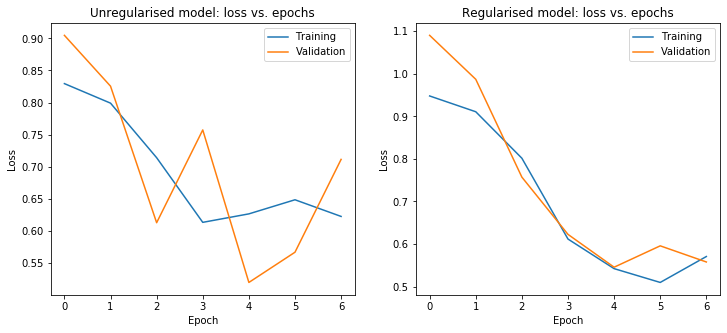

In [40]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()